# Sentence Reconstruction

The purpose of this project is to take in input a sequence of words corresponding to a random permutation of a given english sentence, and reconstruct the original sentence.

The otuput can be either produced in a single shot, or through an iterative (autoregressive) loop generating a single token at a time.


CONSTRAINTS:
* No pretrained model can be used.
* The neural network models should have less the 20M parameters.
* No postprocessing should be done (e.g. no beamsearch)
* You cannot use additional training data.


BONUS PARAMETERS:

A bonus of 0-2 points will be attributed to incentivate the adoption of models with a low number of parameters.

# Dataset

The dataset is composed by sentences taken from the generics_kb dataset of hugging face. We restricted the vocabolary to the 10K most frequent words, and only took sentences making use of this vocabulary.

In [1]:
!pip install datasets
!pip install keras_nlp
!pip install keras==3.3.3

Download the dataset

In [2]:
from datasets import load_dataset
from keras.layers import TextVectorization
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import keras_nlp
import keras
np.random.seed(42)
ds = load_dataset('generics_kb',trust_remote_code=True)['train']

2024-06-12 07:04:53.701429: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-12 07:04:54.527705: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Filter row with length greater than 8.


In [3]:
ds = ds.filter(lambda row: len(row["generic_sentence"].split(" ")) > 8 )
corpus = [ '<start> ' + row['generic_sentence'].replace(","," <comma>") + ' <end>' for row in ds ]
corpus = np.array(corpus)


Create a tokenizer and Detokenizer

In [4]:
tokenizer=TextVectorization( max_tokens=10000, standardize="lower_and_strip_punctuation", encoding="utf-8",) #con il max prende le piu frequenti. ordina i token del vocab dal piu frequente al meno frequente
tokenizer.adapt(corpus)

class TextDetokenizer:
    def __init__(self, vectorize_layer):
        self.vectorize_layer = vectorize_layer
        vocab = self.vectorize_layer.get_vocabulary()
        self.index_to_word = {index: word for index, word in enumerate(vocab)}

    def __detokenize_tokens(self, tokens):
        def check_token(t):
            if t == 3:
                s="<start>"
            elif t == 2:
                s="<end>"
            elif t == 7:
                s="<comma>"
            else:
                s=self.index_to_word.get(t, '[UNK]')
            return s

        return ' '.join([ check_token(token) for token in tokens if token != 0])

    def __call__(self, batch_tokens):
        return [self.__detokenize_tokens(tokens) for tokens in batch_tokens]


detokenizer = TextDetokenizer( tokenizer )
sentences = tokenizer( corpus ).numpy()

2024-06-12 07:05:24.588671: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1928] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 20974 MB memory:  -> device: 0, name: NVIDIA L4, pci bus id: 0000:35:00.0, compute capability: 8.9


Remove from corpus the sentences where any unknow word appears

In [5]:
mask = np.sum( (sentences==1), axis=1) >= 1
original_data = np.delete( sentences, mask , axis=0)

In [6]:
original_data.shape

(241236, 28)

Shuffle the sentences

In [7]:
from tensorflow.keras.utils import Sequence

class DataGenerator(Sequence):
    def __init__(self, data, mode="training", batch_size=32, shuffle=True, seed=42):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.seed = seed
        self.mode = mode
        self.on_epoch_end()

    def __len__(self):
        return int(np.floor(len(self.data) / self.batch_size))

    def __getitem__(self, index):
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        data_batch = np.array([self.data[k] for k in indexes])
        #copy of ordered sequences
        result = np.copy(data_batch)
        #shuffle only the relevant positions for each batch
        for i in range(data_batch.shape[0]):
            np.random.shuffle(data_batch[i,1:data_batch[i].argmin() - 1])
        
        if self.mode=="training":
            # teacher forcing
            target = np.array([np.append(sentence[1:], 0) for sentence in result])
            data_batch_mask = np.where(data_batch==0,0,1)
            result_mask = np.where(result==0,0,1)
            return (data_batch , result, data_batch_mask, result_mask), target
        
        elif self.mode=="test":
            return data_batch, result

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.data))
        if self.shuffle:
            if self.seed is not None:
                np.random.seed(self.seed)
            np.random.shuffle(self.indexes)

In [8]:
# Make a random permutation of training and test set
np.random.seed(42)
# Shuffle the all data
shuffled_indices = np.random.permutation(len(original_data))
shuffled_data = original_data[shuffled_indices]

In [9]:
batch_size = 250
score_batch_size = 500

train_generator = DataGenerator(shuffled_data[:217000], batch_size=batch_size)
val_generator = DataGenerator(shuffled_data[217000:220000], batch_size=1000, mode='test')
test_generator = DataGenerator(shuffled_data[220000:], mode='test', batch_size=score_batch_size)

In [10]:
x, y = test_generator.__getitem__(1)
x = detokenizer(x)
y = detokenizer(y)

for i in range(7):
    print("original: ", y[i])
    print("shuffled: ", x[i])
    print("\n")


original:  <start> positive communication focuses on respect for the child and involves both speaking and listening <end>
shuffled:  <start> and on focuses speaking involves both listening positive for communication and child the respect <end>


original:  <start> hormones are primarily proteins which require interaction with enzymes to regulate bodily processes <end>
shuffled:  <start> enzymes with processes bodily require proteins are hormones primarily regulate to interaction which <end>


original:  <start> some states provide additional unemployment benefits to workers who are disabled <end>
shuffled:  <start> to benefits some states are who additional workers disabled provide unemployment <end>


original:  <start> digital thermometers are as accurate as glass ones <comma> and are faster <end>
shuffled:  <start> glass thermometers <comma> and are accurate are digital as ones as faster <end>


original:  <start> female flagella refers to a sensory organ present in some eukaryotes 

# Metrics

Let s be the source string and p your prediction. The quality of the results will be measured according to the following metric:

1.  look for the longest substring w between s and p
2.  compute |w|/max(|s|,|p|)

If the match is exact, the score is 1.

When computing the score, you should NOT consider the start and end tokens.



The longest common substring can be computed with the SequenceMatcher function of difflib, that allows a simple definition of our metric.

In [11]:
from difflib import SequenceMatcher

def score(s,p):
    match = SequenceMatcher(None, s, p).find_longest_match()
    #print(match.size)
    return (match.size/max(len(p),len(s)))

Let's do an example.

In [12]:
original = "at first henry wanted to be friends with the king of france"
generated = "henry wanted to be friends with king of france at the first"

print("your score is ",score(original,generated))

your score is  0.5423728813559322


The score must be computed as an average of at least 3K random examples taken form the test set.

# What to deliver

You are supposed to deliver a single notebook, suitably commented.
The notebook should describe a single model, although you may briefly discuss additional attempts you did.

The notebook should contain a full trace of the training.
Weights should be made available on request.

You must also give a clear assesment of the performance of the model, computed with the metric that has been given to you.

# Transformer Approach

The neural network I decided to use for this project is based on the original paper where transformers have been introduced:

- *Vaswani, A., Shazeer, N., Parmar, N., Uszkoreit, J., Jones, L., Gomez, A. N., Kaiser, Ł., & Polosukhin, I. (2017). Attention is All You Need. Advances in Neural Information Processing Systems, 30.*

I started by implementing the model as it is described in the original paper and then I brought step-by-step improvements until I obtained the current network.  

First of all, I changed the `DataGenerator` class in order to adapt it to how I constructed the model. It has two different types of outputs in the \_\_get_item\_\_() method, depending on where it is called:
- `mode="training"` to construct the _train generator_ to be used in the _model.fit()_, which provides also the _masks_ for the padding elements in the sequences and the _target_, which contains the sequence shifted to the right of one token for the **teacher forcing tecnique**;  
- `mode="test"` to construct the _test generator_ and the _validation generator_, used to make the predictions. In this case the _validation data_ are a fraction of the _training data_ given by the dataset.

## Parameters ##
Here is the list of the hyperparameters used in the model:
- `epochs`: I put a high number of epochs for the training since I implemented a way of stopping earlier to maximize the final score (explained below);  
- `seq_len`: maximum length of the sequence of tokens;
- `vocab_size`: number of tokens in the vocabulary;  
- `num_layers`: number of encoders and decoders in the model;  
- `embed_dim`: dimension of the **embedding vectors** of the tokens;  
- `feed_forward_dim`: dimension used in the dense layers in the _feed-forward section_ of the **transformer blocks** (encoder-decoder);  
- `num_heads`: number of _attention heads_ in the **transformer blocks**;  
- `dropout_rate`: **dropout rate** used to enhance _generalization_ on test/validation data;
- `batch_size`: defined above, I put a relatively high **batch_size**, in order to have a trade off between learning speed and robustness.

The choice of the values above are the result of different trials, each with different ratios among them. I decided to manipulate mostly the **embedding dimension** and the **feed-forward dimension**, which are the crucial hyperparameters for the number of parameters of the model and its performance.  
The **number of heads** is set through a trade-off between the length of the sequence and a low value, chosen according to the original paper (a scaled number of the one provided by the original paper).  
Concerning the **dropout rate**, I set it to a relatively low value in order to avoid overfitting without causing underfitting.

In [13]:
epochs = 200
seq_len = 28
vocab_size = 10000
num_layers = 8
embed_dim = 128
feed_forward_dim = 512
num_heads = 14
dropout_rate = 0.1

## Learning Rate Schedule and Optimizer ##
I first implemented a custom learning schedule, following the paper by _Vanswani et al. [2017]_ and the performance was encouraging, but what made me improve even more the final score is the usage of the `CosineDecayRestarts()`, instead.

The pronciple is that with the custom scheduler the model was stuck into a _plateau_, so I decided to use the **restart tecnique** to escape from it. The result is a big improvement in the general performance of the model, both on the training accuracy and in the score, gaining 0.02 on the final _test score_ in the average.

The related paper is the following:

- *Loshchilov, I., & Hutter, F. (2017). SGDR: Stochastic Gradient Descent with Warm Restarts.*


In [14]:
## Old schedule ##

class MyLRSchedule(keras.optimizers.schedules.LearningRateSchedule):

    def __init__(self, d_model, warmup_steps=4000):
        super().__init__()
        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)
        self.warmup_steps = warmup_steps

    def __call__(self, step):
        step = tf.cast(step, dtype=tf.float32)
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)
        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

##----------------------------------------------------------------------------------------##

## New schedule ##

restart_scheduler = keras.optimizers.schedules.CosineDecayRestarts(
    8e-04,
    3e04,
    t_mul=0.5,
    m_mul=0.01 )

## Loss and Accuracy
I have rewritten the **loss function** and the **accuracy** to be used in the _model.fit()_ method in order to compute the `Sparse Categorical Crossentropy` and the `accuracy` only on the real tokens of the sequences and not on the paddings, respectively.

In [15]:
def masked_loss(label, pred):

    mask = label != 0

    loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=False, 
        reduction='none')
    loss = loss_object(label, pred)

    mask = tf.cast(mask, dtype=loss.dtype)
    loss *= mask

    return tf.reduce_sum(loss)/tf.reduce_sum(mask)

def masked_accuracy(label, pred):

    pred = tf.argmax(pred, axis=2)
    label = tf.cast(label, pred.dtype)
    
    match = label == pred
    mask = label != 0
    match = match & mask
    
    match = tf.cast(match, dtype=tf.float32)
    mask = tf.cast(mask, dtype=tf.float32)
    return tf.reduce_sum(match)/tf.reduce_sum(mask)

In [16]:
def clean_sentence(x):
    x = x.replace('<start>', '').replace('<end>', '').replace('<pad>', '').strip()
    return x

In [17]:
class Translator(tf.Module):
    def __init__(self, transformer, tokenizer):
        self.transformer = transformer
        self.tokenizer = tokenizer

    def __call__(self, sentences, max_length=28):
        batch_size = sentences.shape[0]

        bow = [[word for word in sentence if word not in [3, 2, 0]] for sentence in sentences]
        output = [[3] for _ in range(batch_size)]

        for i in range(1, max_length):
            predictions = np.array(self.transformer((np.array(sentences), np.array(output), np.where(np.array(sentences)==0,0,1),np.where(np.array(output)==0,0,1)), training=False))
            # remove useless dimensions
            predictions = predictions[:, -1, :]
            for j in range(batch_size):
                if len(bow[j]) == 0:
                    cand_token = 2
                else:
                    # choose index with highest score
                    s_prediction = predictions[j, np.array(bow[j])]
                    cand_index = np.argmax(s_prediction)
                    cand_token = bow[j][cand_index]
                    del bow[j][cand_index]
                output[j].append(cand_token)
        return output

## Validation Callback ##
This callback is what made me improve the score significantly. This `ValidationCallback` class is designed to monitor the performance of the model during training _performing the score on the validation generator_.  

It computes prediction on the validation data and if the current **validation score** is better than the previous maximum score, the callback resets the patience counter and updates the maximum score, saving the best model's weights. If the score does not improve, the **patience** counter is incremented. If the patience counter exceeds a specified maximum patience, the training stops, and the model's weights are reverted to the best model weights.

This callback allows to have a longer training and prevents overfitting on the validation data, falling into an increment in the score on the test of 0.03 in the average.

In [18]:
from tensorflow.keras.callbacks import Callback

class ValidationCallback(Callback):
    def __init__(self, tokenizer,generator, batch_size, max_patience):
        super(ValidationCallback, self).__init__()
        self.tokenizer = tokenizer
        self.generator = generator
        self.batch_size = batch_size
        self.max_patience = max_patience
        self.patience = 0
        self.max_score = 0
        
    def on_epoch_end(self, epoch, logs=None):
        score_batch_size = self.batch_size
        total_val_size = 3000
        tot_score = 0
        #print(type(self.model))
        self.model.save_weights('current_model.weights.h5')
        model = get_transformer()
        model.load_weights('current_model.weights.h5')
        translator = Translator(model, self.tokenizer)
        for i in range(total_val_size // score_batch_size):
            shuffled, ordered = self.generator[i]
            y_pred = translator(shuffled)
            pred_sentences = detokenizer(y_pred)
            original_sentences = detokenizer(ordered)
            b_score = 0
            for j in range(score_batch_size):
                b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))
                
            tot_score += b_score
            print(f"\nValidation Score after batch {i+1}: {tot_score / ((i+1) * score_batch_size)}")
        final_score = tot_score / total_val_size
        if final_score >= self.max_score:
            self.patience = 0
            self.max_score = final_score
            self.model.save_weights('best_model.weights.h5')
        else:
            if self.patience == self.max_patience:
                self.model.load_weights('best_model.weights.h5')
                self.model.stop_training = True
            else:
                self.patience +=1
        logs['val_score'] = final_score

In [19]:
score_callback = ValidationCallback(
    tokenizer=tokenizer,
    generator=val_generator,
    batch_size=1000,
    max_patience=8 )

## Model ##
The architecture of the model is quite the one described by the paper by _Vanswani et al. [2017]_ with the difference that I decided to delete the positional encoding on the encoder.  

In the first trials, I used the original transformer structure, but I thought that the model might also learn the shuffled positions given in input to the encoder. Hence, I have deleted the _positional encoding layer_ on the encoder input and the results were encouraging.

In addition, I put only one _embedding layer_ instead of two and I used it for both encoder and the decoder embeddings. This choice made me save parameters for the model.

In [20]:
def get_transformer():
    padding_mask_enc = keras.Input( shape=(None,), name="padding_mask_enc")
    padding_mask_dec = keras.Input( shape=(None,), name="padding_mask_dec")
    
    # Encoder
    encoder_inputs = keras.Input(shape=(None,), name="encoder_inputs")
    embedding = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
    x = embedding(encoder_inputs)

    for i in range(num_layers-1):
        x = keras_nlp.layers.TransformerEncoder(
            intermediate_dim=feed_forward_dim, 
            num_heads=num_heads, 
            dropout=dropout_rate
        )(inputs=x, padding_mask=padding_mask_enc)
    encoder_outputs = keras_nlp.layers.TransformerEncoder(
            intermediate_dim=feed_forward_dim, 
            num_heads=num_heads, 
            dropout=dropout_rate
        )(inputs=x, padding_mask=padding_mask_enc)

    # Decoder
    decoder_inputs = keras.Input(shape=(None,), name="decoder_inputs")
    decoder_embedding = embedding(decoder_inputs)
    x = keras_nlp.layers.PositionEmbedding(
        sequence_length=seq_len
        )(decoder_embedding)
    x += decoder_embedding

    for i in range(num_layers):
        x = keras_nlp.layers.TransformerDecoder(
            intermediate_dim=feed_forward_dim, 
            num_heads=num_heads, 
            dropout=dropout_rate
        )(decoder_sequence=x, encoder_sequence=encoder_outputs, decoder_padding_mask=padding_mask_dec, encoder_padding_mask=padding_mask_enc)
    decoder_outputs = keras.layers.Dense(
        vocab_size, 
        activity_regularizer='l2', 
        activation="softmax"
        )(x)
    
    transformer = keras.Model(
        [encoder_inputs, decoder_inputs, padding_mask_enc, padding_mask_dec],
        decoder_outputs,
        name="transformer",
    )
    return transformer

transformer = get_transformer()

In [21]:
opt = keras.optimizers.Adam(learning_rate=restart_scheduler,beta_1=0.9, beta_2=0.98,epsilon=1e-09)
transformer.compile(optimizer=opt, loss=masked_loss, metrics=[masked_accuracy])
transformer.summary()

Model: "transformer"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 128) │  1,280,000 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_enc    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encoder │ (None, None, 128) │    197,242 │ embedding[0][0],  │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ position_embedding  │ (None, None, 128) │      3,584 │ embedding[1][0]   │
│ (PositionEmbedding) │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, None, 128) │          0 │ position_embeddi… │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ padding_mask_dec    │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 128) │    197,242 │ transformer_enco… │
│ (TransformerEncode… │                   │            │ padding_mask_enc… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decoder │ (None, None, 128) │    262,516 │ add[0][0],        │
│ (TransformerDecode… │                   │            │ padding_mask_dec… │
│                     │                   │            │ padding_mask_enc… │
│                     │                   │            │ transformer_enco

 Total params: 6,251,648 (23.85 MB)

 Trainable params: 6,251,648 (23.85 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/200


/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1718176076.717769    3460 service.cc:145] XLA service 0x7f6744002120 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1718176076.717824    3460 service.cc:153]   StreamExecutor device (0): NVIDIA L4, Compute Capability 8.9
2024-06-12 07:07:57.833394: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1718176079.735126    3460 assert_op.cc:38] Ignoring Assert operator compile_loss/masked_loss/sparse_categorical_crosse

868/868 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 6.0531 - masked_accuracy: 0.2853

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 14, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(



Validation Score after batch 1: 0.36263735948009757

Validation Score after batch 2: 0.35876396385279735

Validation Score after batch 3: 0.35785810911537924
868/868 ━━━━━━━━━━━━━━━━━━━━ 253s 126ms/step - loss: 6.0521 - masked_accuracy: 0.2854 - val_score: 0.3579
Epoch 2/200
868/868 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step - loss: 3.8387 - masked_accuracy: 0.6289
Validation Score after batch 1: 0.40135839932322953

Validation Score after batch 2: 0.39667629883375766

Validation Score after batch 3: 0.39555093563979227
868/868 ━━━━━━━━━━━━━━━━━━━━ 109s 126ms/step - loss: 3.8385 - masked_accuracy: 0.6289 - val_score: 0.3956
Epoch 3/200
868/868 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3.4006 - masked_accuracy: 0.7182
Validation Score after batch 1: 0.4246258436218117

Validation Score after batch 2: 0.417099634035945

Validation Score after batch 3: 0.4179236859001427
868/868 ━━━━━━━━━━━━━━━━━━━━ 110s 126ms/step - loss: 3.4005 - masked_accuracy: 0.7182 - val_score: 0.4179
Epoch 4/200
868/868 ━

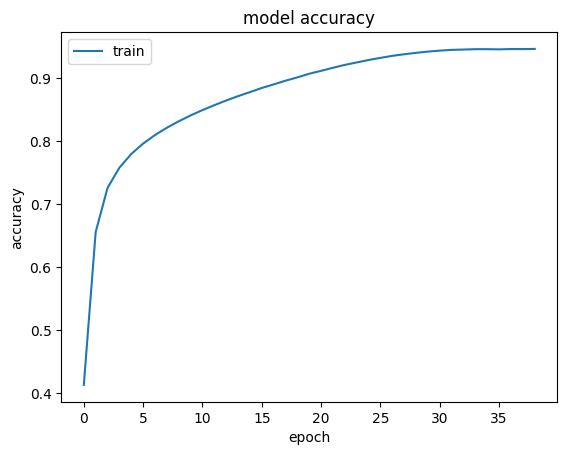

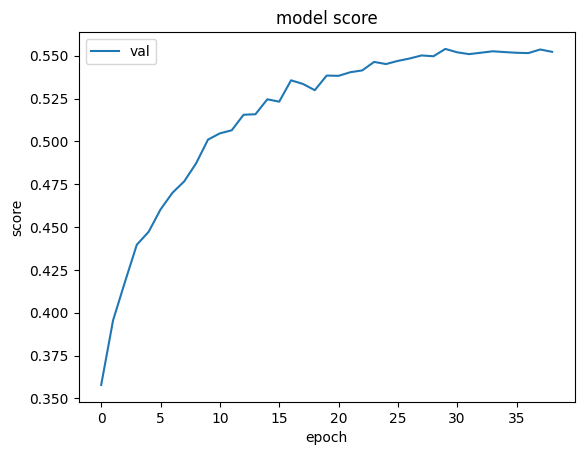

In [22]:
history = transformer.fit(
    train_generator,
    epochs=epochs,
    callbacks=score_callback )

#  "Accuracy"
plt.plot(history.history['masked_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()
# "Loss"
plt.plot(history.history['val_score'])
plt.title('model score')
plt.ylabel('score')
plt.xlabel('epoch')
plt.legend(['val'], loc='upper left')
plt.show()

## To summerize ##
I implemented a Transformer architecture for my neural network model. Throughout the process, I explored various configurations and tuned hyperparameters to optimize the model's performance. The Transformer model, with its self-attention mechanism and ability to handle long-range dependencies, demonstrated significant improvements in this task.

In addition to the Transformer, I also experimented with LSTM-based models. Despite fine-tuning and optimizing the LSTM configurations, their performance was consistently behind the Transformer model. The Transformer's superior ability to capture complex patterns and dependencies in the data was evident in the results.

Overall, the Transformer model proved to be the most effective approach for the task, performing on the test as it is shown in the next cell.

In [27]:
transformer.load_weights('best_model.weights.h5')

In [28]:
total_test_size = 3000
score_ = 0
translator = Translator(transformer,tokenizer)

for i in range(total_test_size//score_batch_size):
    shuffled, ordered = test_generator[i]
    y_pred = translator(shuffled)

    ## Score for each batch ##
    b_score = 0

    pred_sentences = detokenizer(y_pred)
    original_sentences = detokenizer(ordered)

    for j in range(score_batch_size) :
        b_score += score(clean_sentence(original_sentences[j]), clean_sentence(pred_sentences[j]))

    score_ += b_score
    print("Score as of batch ", i, ": ", score_/((i+1)*score_batch_size))

score_ = score_/total_test_size
print("\n-------------- BATCHES OVER ---------------")
print("Final score: ", score_)

/home/zeus/miniconda3/envs/cloudspace/lib/python3.10/site-packages/keras/src/ops/nn.py:545: UserWarning: You are using a softmax over axis 3 of a tensor of shape (500, 14, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


Score as of batch  0 :  0.5408544862289913
Score as of batch  1 :  0.5474059523544101
Score as of batch  2 :  0.5467846483400424
Score as of batch  3 :  0.5484580567202124
Score as of batch  4 :  0.5464168631964419
Score as of batch  5 :  0.5445841940494262

-------------- BATCHES OVER ---------------
Final score:  0.5445841940494262


 > ##### This code is the result of a work of refinement of the parameters, since my goal is to make a trade-off between the best possible score on 20M parameters and a low number of parameters, in order to get the 2 bonus points. #####
> ##### The same model, tuned to be near the 20M parameters, has reached the best score around the following: #####
> ### 0.565 to 0.57 ###